model 3 

✅ Found saved weights. Loading animal_expert_97acc.pth...
⏳ Running evaluation on test set...


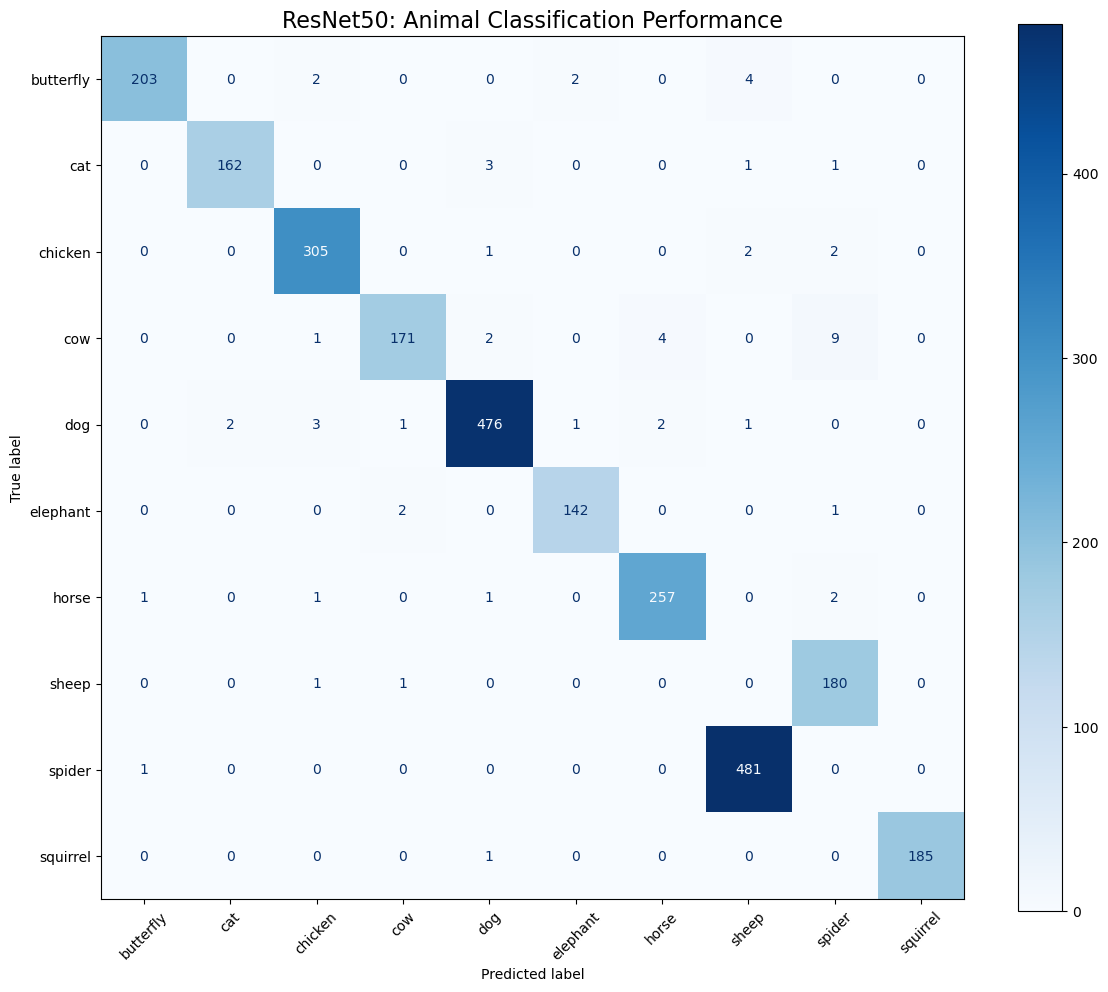

🏁 Evaluation complete.


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1️ DATASET CONFIGURATION
# ---------------------------------------------------------
dataset_path = r"C:\Users\rache\Downloads\archive\raw-img"

# Dictionary to translate Italian folder names to English
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", 
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
    "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", 
    "ragno": "spider"
}

data = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        label = translate.get(folder, folder)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append([os.path.join(folder_path, file), label])

df = pd.DataFrame(data, columns=["image_path", "label"])
label_mapping = dict(enumerate(df['label'].astype('category').cat.categories))
num_classes = len(label_mapping)

# Stratified split to keep 10% for testing
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# ---------------------------------------------------------
# 2️ DATA LOADERS & TRANSFORMS
# ---------------------------------------------------------
class AnimalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_to_idx = {v: k for k, v in label_mapping.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = self.label_to_idx[self.df.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

# ImageNet normalization standards
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

train_loader = DataLoader(AnimalDataset(train_df, train_transform), batch_size=32, shuffle=True)
test_loader = DataLoader(AnimalDataset(test_df, test_transform), batch_size=32)

# ---------------------------------------------------------
# 3️ MODEL LOADING (ResNet50)
# ---------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_resnet50():
    # Loading pre-trained ResNet50
    model = models.resnet50(weights='DEFAULT')
    
    # Freezing the convolutional base (Transfer Learning)
    for param in model.parameters():
        param.requires_grad = False
    
    # Replacing the final Fully Connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

model = load_resnet50()
model_save_path = 'animal_expert_97acc.pth'

# ---------------------------------------------------------
# 4️ INFERENCE & EVALUATION (Confusion Matrix)
# ---------------------------------------------------------
# Checking if weights exist to load them instead of re-training
if os.path.exists(model_save_path):
    print(f"✅ Found saved weights. Loading {model_save_path}...")
    model.load_state_dict(torch.load(model_save_path))
else:
    print("❌ No saved weights found. Please run the training loop first.")

model.eval()
all_preds, all_labels = [], []

print("⏳ Running evaluation on test set...")
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate and display the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))

# Using Matplotlib's 'Blues' or 'Greens' for a clean look
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('ResNet50: Animal Classification Performance', fontsize=16)
plt.tight_layout()
plt.show()

print("🏁 Evaluation complete.")

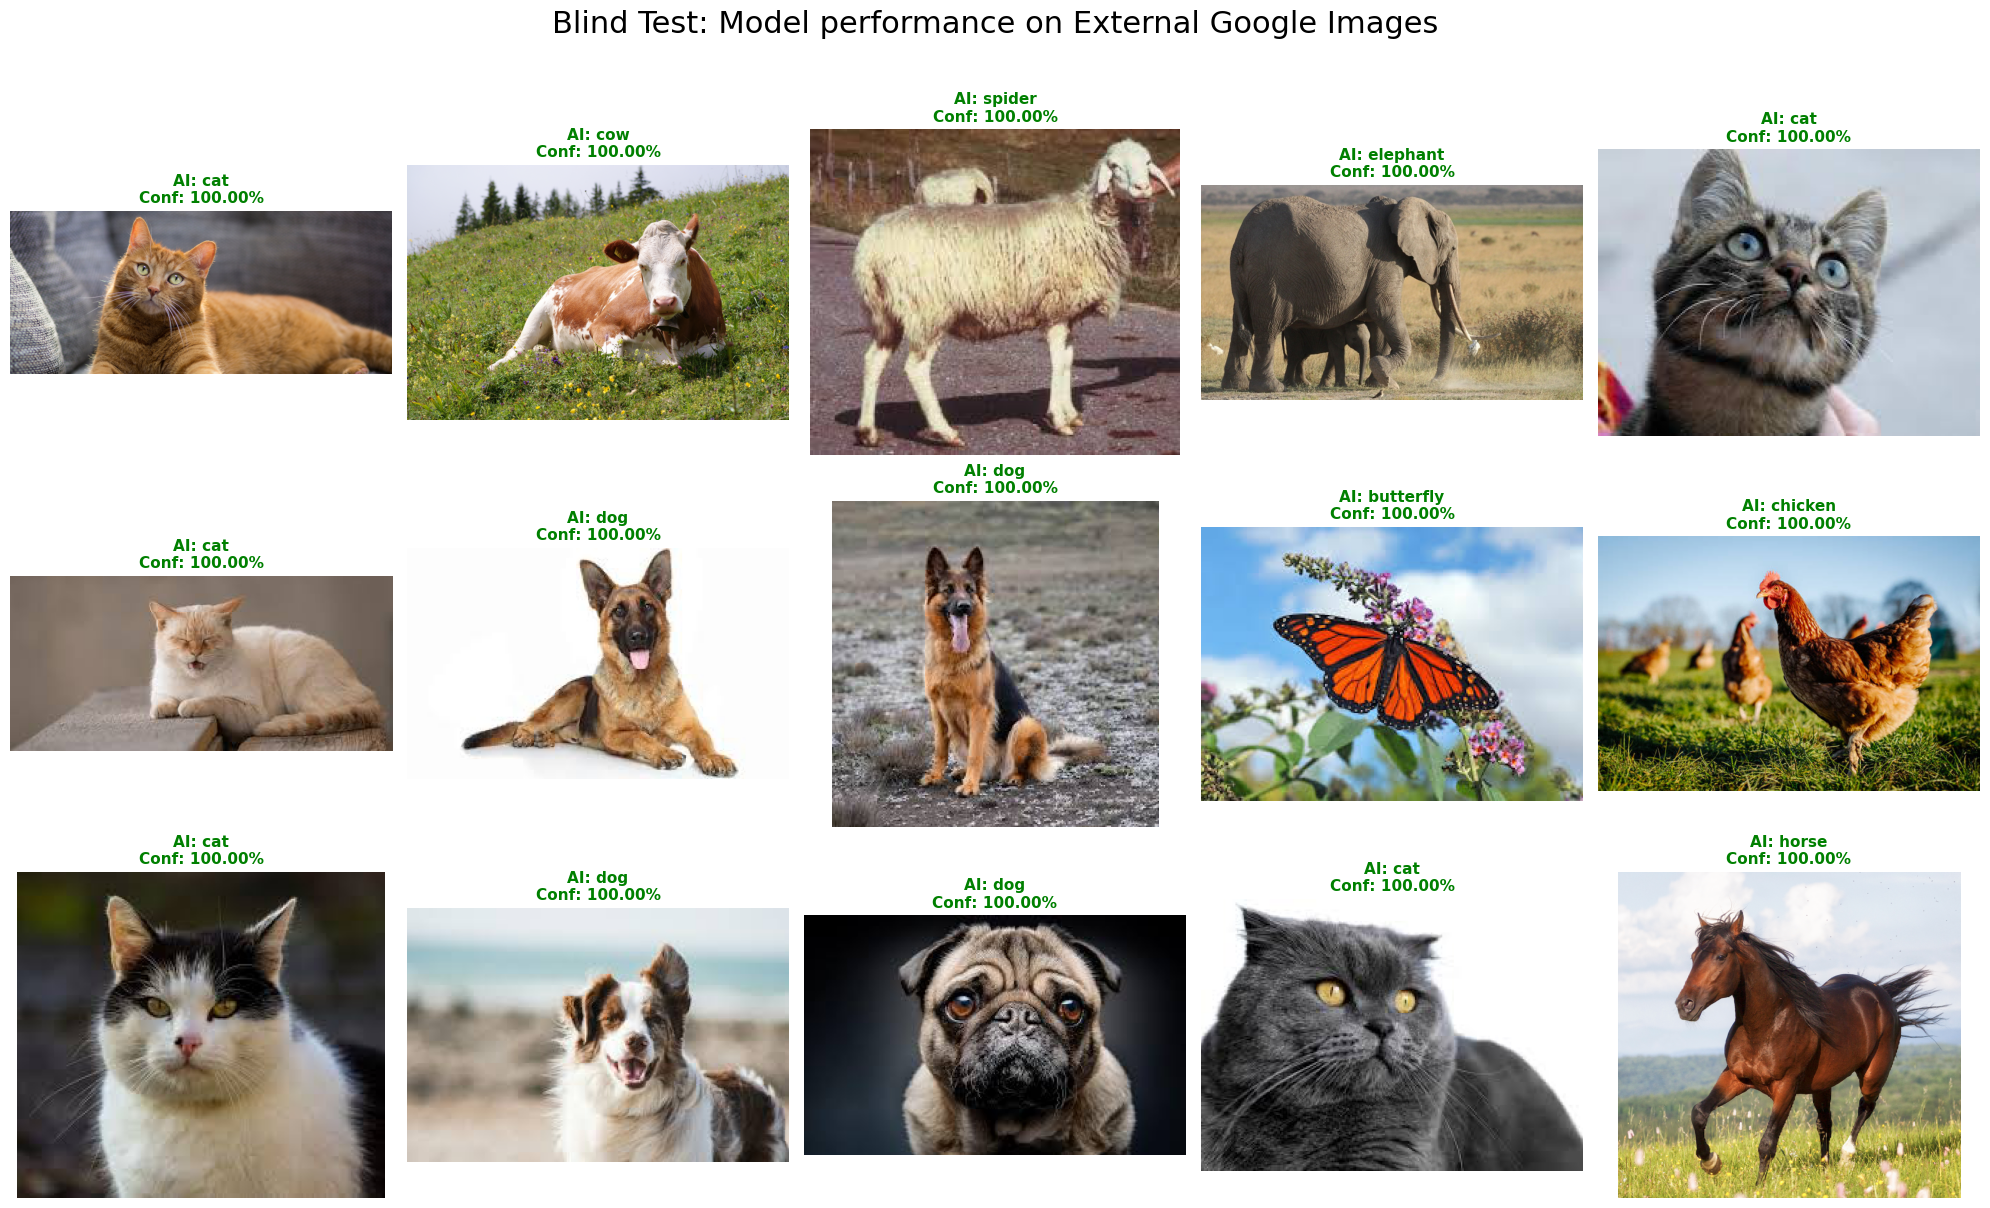

✅ Tested 15 images from external_test folder.


In [ ]:
# ---------------------------------------------------------
# 8️ EXTERNAL VALIDATION: Testing on Google Images
# ---------------------------------------------------------
import os
from PIL import Image

# 1. Create a folder named 'external_test' in your VS Code project folder
# 2. Put your 14 to 20 images inside (dog, cat, spider, etc.)
teste_Photos = 'Test photos/'

if not os.path.exists(teste_Photos):
    os.makedirs(teste_Photos)
    print(f"📁 Folder '{teste_Photos}' created. Add your images and run again!")
else:
    # Get list of images
    external_images = [f for f in os.listdir(teste_Photos) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(external_images) == 0:
        print("⚠️ No images found in 'external_test/'. Please add some animal photos!")
    else:
        model.eval()
        plt.figure(figsize=(20, 15))
        
        # We test up to 20 images
        num_to_show = min(len(external_images), 20)
        
        for i in range(num_to_show):
            img_path = os.path.join(teste_Photos, external_images[i])
            
            # Load and convert image
            raw_img = Image.open(img_path).convert('RGB')
            
            # Apply the SAME transforms as used during training
            # (Resize to 224, Tensor, and ImageNet Normalization)
            input_tensor = test_transform(raw_img).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = model(input_tensor)
                # Get probabilities and the highest class
                probabilities = torch.nn.functional.softmax(output, dim=1)
                confidence, pred = torch.max(probabilities, 1)
                predicted_label = label_mapping[pred.item()]
            
            # Plotting the result
            plt.subplot(4, 5, i + 1)
            plt.imshow(raw_img)
            
            # Color coding: Blue for the AI's "thought"
            title_color = 'green' if confidence.item() > 0.8 else 'orange'
            plt.title(f"AI: {predicted_label}\nConf: {confidence.item():.2%}", 
                      fontsize=11, color=title_color, fontweight='bold')
            plt.axis('off')
            
        plt.tight_layout()
        plt.suptitle("Blind Test: Model performance on External Google Images", fontsize=22, y=1.05)
        plt.show()

print(f"✅ Tested {num_to_show} images from external_test folder.")